# Toy Hierarchical Model

In [1]:
import jax
import jax.numpy as jnp
from jaxtyping import Array, Float
from dataclasses import dataclass

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax.distributions as tfd

import numpy as np

import os

from scipy.stats import bootstrap

from coinem.model import AbstractModel
from coinem.dataset import Dataset

## Model

We consider generating data $y$ from a hierarchical Gaussian model with real-valued hyperparameter $\theta = 1$:

$$ p_\theta(x, y) = \mathcal{N}(y; x, I_{D_y}) \mathcal{N}(x; \theta I_{D_y}, I_{D_y}) $$

### Model in code:
To create our model we just inherit from the provided `AbstractModel`.

In [2]:
from jaxtyping import Array, Float, PyTree


@dataclass
class HierarchicalModel(AbstractModel):
    """Base class for p(θ, x)."""
    
    def log_prob(self, latent: Float[Array, "D"], theta: Float[Array, "Q"], data: Dataset) -> Float[Array, ""]:
        """Compute gradient of the objective function at x.

        Args:
            latent (Float[Array, "D"]): Input weights of shape (D,).
            theta (Float[Array, "Q"]): Parameters of shape (Q,).

        Returns:
            Float[Array, ""]: log-probability of the data.
        """
        log_prob_y_given_x = tfd.MultivariateNormalDiag(jnp.atleast_1d(latent.squeeze())).log_prob(jnp.atleast_1d(data.y.squeeze())).sum() # \mathcal{N}(y; x, I_{D_y}) 
        log_prob_x_given_theta = tfd.Normal(theta, scale=1.0).log_prob(jnp.atleast_1d(latent.squeeze())).sum() # \mathcal{N}(x; \theta I_{D_y}, I_{D_y})

        # Compute log-probability.
        return (log_prob_y_given_x + log_prob_x_given_theta).squeeze() # log p(y|x) + log p(x|theta)
    
    def optimal_theta(self, latent_particles: PyTree[Float[Array, "N D *"]]) -> PyTree[Float[Array, "Q *"]]:
        return latent_particles.mean().reshape(-1) # WARNING: This assumes a single dimension for the "x"!

### Dataset:
We draw one observation $y$ from the model.

In [3]:
Ny = 1
Dy = 100
key = jr.PRNGKey(42)
theta = jnp.array([1.0])

key_y, key_latent = jr.split(key)
latent = theta + jr.normal(key_latent, (1, Dy))
y = jr.normal(key_y, (Ny, Dy)) + latent

theta_star = jnp.sum(y)/Dy

posterior_mean = 0.5 * (y + theta*jnp.ones_like(y))
posterior_mean_empirical = 0.5 * (y + theta_star * jnp.ones_like(y))

### Unit tests:
We test the score of the latent function and average log-probability of the model.

In [4]:
# Define the model:
model = HierarchicalModel()
data = Dataset(y=y)

# Unit tests:
assert jnp.allclose(model.score_latent(latent, theta, data), (y + theta - 2.0* latent)) # Gradient of log p(y|x) wrt x
assert jnp.allclose(model.score_theta(latent, theta, data), Dy * (latent.mean() - theta)) # Gradient of log p(y|x) wrt theta

### EM algorithm

For this example we can find the EM algorithm in closed form, for the theta updates given below.

In [5]:
def em(model, data, theta, K):
    """Expectation Maximization Algorithm. Returns parameter estimates."""

    def em_step(theta, k):
        new_theta = theta/2.0 + data.y.mean()/2.0
        return new_theta, theta

    _, thetas = jax.lax.scan(em_step, theta, jnp.arange(K))

    return thetas

from coinem.time_zoo import coin_svgd, ada_svgd, soul, pgd, ada_pgd

#coin_svgd(model, data, X0, th0, 20.0)

# Experiment 1: Parameter Estimates and Posterior Means [Fig. 1]

We first run all of the methods over a grid of learning rates

In [6]:
from coinem.time_zoo import coin_svgd, ada_svgd, soul, pgd, ada_pgd
from coinem.marginal_zoo import marginal_coin_svgd, marginal_ada_svgd, marginal_soul, marginal_pgd

step_size_list = jnp.logspace(-5,3,50) # step sizes

n_reps = 10 # number of repeats

K = 1.0 # number of iterations
step_size_list = [1, 5, 10, 50, 100, 500, 1000]

mse_ada_pgd_all = np.zeros((n_reps, len(step_size_list)))
mse_ada_svgd_all = np.zeros((n_reps, len(step_size_list)))
mse_soul_all = np.zeros((n_reps, len(step_size_list)))
mse_coin_all = np.zeros((n_reps, len(step_size_list)))

latent_mse_pgd_all =  np.zeros((n_reps, len(step_size_list)))
latent_mse_svgd_all = np.zeros((n_reps, len(step_size_list)))
latent_mse_soul_all = np.zeros((n_reps, len(step_size_list)))
latent_mse_coin_all = np.zeros((n_reps, len(step_size_list)))

latent_var_pgd_all = np.zeros((n_reps, len(step_size_list)))
latent_var_svgd_all = np.zeros((n_reps, len(step_size_list)))
latent_var_soul_all = np.zeros((n_reps, len(step_size_list)))
latent_var_coin_all = np.zeros((n_reps, len(step_size_list)))



    
for i, rep in enumerate(range(n_reps)):

    print("Repetition: " + str(i+1) + "/" + str(n_reps))

    key = jr.PRNGKey(int(i))
    Ny = 1
    Dy = 1

    theta = jnp.array([1.0])

    key_y, key_latent = jr.split(key)
    latent = theta + jr.normal(key_latent, (1, Dy))
    y = jr.normal(key_y, (Ny, Dy)) + latent

    theta_star = jnp.sum(y)/Dy

    posterior_mean = 0.5 * (y + theta*jnp.ones_like(y))
    posterior_mean_empirical = 0.5 * (y + theta_star * jnp.ones_like(y))

    model = HierarchicalModel()
    data = Dataset(y=y)

    for j, N in enumerate(step_size_list):

        th0 = .1*jr.normal(key, (1,))
        X0 = 1*jr.normal(key, (N, Dy)) 

        if (j+1) % 10 == 0: 
            print("LR: " + str(j+1) + "/" + str(len(step_size_list)))
        latent_pgd, theta_ada_pgd = ada_pgd(model, data, X0, th0, K, latent_step_size = 0.1, theta_step_size = 0.1)
        latent_svgd, theta_ada_svgd = ada_svgd(model, data, X0, th0, K, theta_step_size = 0.9, latent_step_size = 0.9)
        latent_soul, theta_soul = soul(model, data, X0, th0, K, theta_step_size = 0.01, latent_step_size = 0.01)
        latent_coin, theta_coin = coin_svgd(model, data, X0, th0, K)
        
        mse_ada_pgd = (theta_ada_pgd[-1] - theta_star)**2
        mse_ada_svgd = (theta_ada_svgd[-1] - theta_star)**2
        mse_soul = (theta_soul[-1] - theta_star)**2
        mse_coin = (theta_coin[-1] - theta_star) ** 2

        latent_mse_pgd = jnp.mean((latent_pgd.mean(axis=0) - posterior_mean_empirical)**2)
        latent_mse_svgd = jnp.mean((latent_svgd.mean(axis=0) - posterior_mean_empirical)**2)
        latent_mse_soul = jnp.mean((latent_soul.mean(axis=0) - posterior_mean_empirical)**2)
        latent_mse_coin = jnp.mean((latent_coin.mean(axis=0) - posterior_mean_empirical)**2)

        mse_ada_pgd_all[i,j] = mse_ada_pgd
        mse_ada_svgd_all[i,j] = mse_ada_svgd
        mse_soul_all[i,j] = mse_soul
        mse_coin_all[i,j] = mse_coin



        #mu1_pgd = latent_pgd.mean(axis=2) ** 2 # E[x]^2, expectation over particles

        latent_mse_pgd_all[i,j] = latent_mse_pgd
        latent_mse_svgd_all[i,j] = latent_mse_svgd
        latent_mse_soul_all[i,j] = latent_mse_soul
        latent_mse_coin_all[i,j] = latent_mse_coin

        latent_var_pgd_all[i, j] = ((0.5 - latent_pgd.var(axis=0))**2).mean()
        latent_var_svgd_all[i, j] = ((0.5-latent_svgd.var(axis=0))**2).mean()
        latent_var_soul_all[i, j] = ((0.5-latent_soul.var(axis=0))**2).mean()
        latent_var_coin_all[i, j] = ((0.5-latent_coin.var(axis=0))**2).mean()
        



Repetition: 1/10
Repetition: 2/10
Repetition: 3/10
Repetition: 4/10
Repetition: 5/10
Repetition: 6/10
Repetition: 7/10
Repetition: 8/10
Repetition: 9/10
Repetition: 10/10


### (a) MSE vs Learning Rate [Fig. 1(a), Fig. 6(a), Fig. 7(a), Fig. 9(a)]

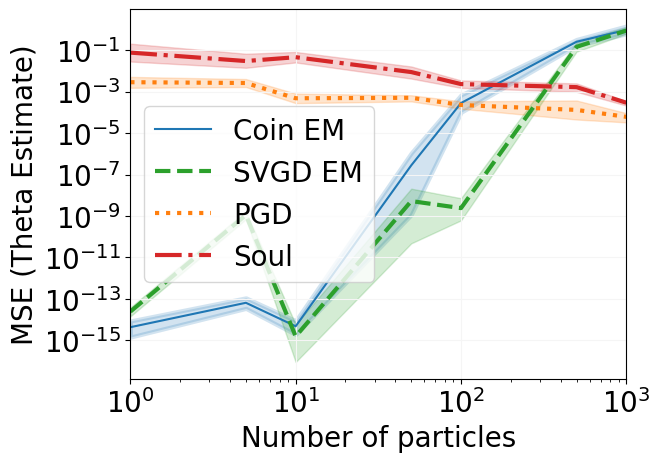

In [7]:
# compute confidence intervals
data_ada_pgd = (mse_ada_pgd_all,)  # samples must be in a sequence
res_ada_pgd = bootstrap(data_ada_pgd, np.mean, confidence_level=0.9)

data_ada_svgd = (mse_ada_svgd_all,) 
res_ada_svgd = bootstrap(data_ada_svgd, np.mean, confidence_level=0.9)

data_soul = (mse_soul_all,) 
res_soul = bootstrap(data_soul, np.mean, confidence_level=0.9)

data_coin = (mse_coin_all,) 
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

plt.plot(step_size_list, np.mean(mse_coin_all, 0), color="C0", label="Coin EM")
plt.fill_between(step_size_list, res_coin.confidence_interval[0], res_coin.confidence_interval[1], color="C0", alpha=0.2, linewidth=3)

plt.plot(step_size_list, np.mean(mse_ada_svgd_all,0), color="C2", linestyle='dashed', label="SVGD EM", linewidth=3)
plt.fill_between(step_size_list, res_ada_svgd.confidence_interval[0], res_ada_svgd.confidence_interval[1], alpha=0.2, color="C2")

plt.plot(step_size_list, np.mean(mse_ada_pgd_all,0), color="C1", linestyle='dotted', label="PGD", linewidth=3)
plt.fill_between(step_size_list, res_ada_pgd.confidence_interval[0], res_ada_pgd.confidence_interval[1], alpha=0.2, color="C1")

plt.plot(step_size_list, np.mean(mse_soul_all,0), color="C3", linestyle='dashdot', label="Soul", linewidth=3)
plt.fill_between(step_size_list, res_soul.confidence_interval[0], res_soul.confidence_interval[1], alpha=0.2, color="C3")

#plt.ylim(1e-16,10000)
plt.xscale("log")
plt.yscale("log") 
plt.legend(prop={'size': 20})
plt.margins(x=0)
plt.xlabel("Number of particles", fontsize=20)
plt.ylabel(f"MSE (Theta Estimate)", fontsize=20)
plt.grid(color='whitesmoke')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig(f"mse_toy_example_time.pdf", bbox_inches='tight')


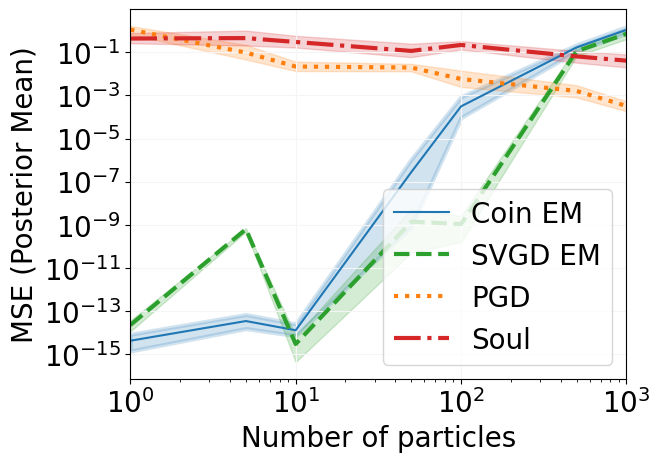

In [8]:
# compute confidence intervals
data_ada_pgd = (latent_mse_pgd_all,)  # samples must be in a sequence
res_ada_pgd = bootstrap(data_ada_pgd, np.mean, confidence_level=0.9)

data_ada_svgd = (latent_mse_svgd_all,) 
res_ada_svgd = bootstrap(data_ada_svgd, np.mean, confidence_level=0.9)

data_soul = (latent_mse_soul_all,) 
res_soul = bootstrap(data_soul, np.mean, confidence_level=0.9)

data_coin = (latent_mse_coin_all,) 
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

plt.plot(step_size_list, np.mean(latent_mse_coin_all, 0), color="C0", label="Coin EM")
plt.fill_between(step_size_list, res_coin.confidence_interval[0], res_coin.confidence_interval[1], color="C0", alpha=0.2, linewidth=3)

plt.plot(step_size_list, np.mean(latent_mse_svgd_all,0), color="C2", linestyle='dashed', label="SVGD EM", linewidth=3)
plt.fill_between(step_size_list, res_ada_svgd.confidence_interval[0], res_ada_svgd.confidence_interval[1], alpha=0.2, color="C2")

plt.plot(step_size_list, np.mean(latent_mse_pgd_all,0), color="C1", linestyle='dotted', label="PGD", linewidth=3)
plt.fill_between(step_size_list, res_ada_pgd.confidence_interval[0], res_ada_pgd.confidence_interval[1], alpha=0.2, color="C1")

plt.plot(step_size_list, np.mean(latent_mse_soul_all,0), color="C3", linestyle='dashdot', label="Soul", linewidth=3)
plt.fill_between(step_size_list, res_soul.confidence_interval[0], res_soul.confidence_interval[1], alpha=0.2, color="C3")

#plt.ylim(1e-16,10000)
plt.xscale("log")
plt.yscale("log") 
plt.legend(loc='lower right',prop={'size': 20})
plt.margins(x=0)
plt.xlabel("Number of particles", fontsize=20)
plt.ylabel(f"MSE (Posterior Mean)", fontsize=20)
plt.grid(color='whitesmoke')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig(f"mse_latent_mean_time.pdf", bbox_inches='tight')


/Users/danieldodd/miniforge3/envs/coin/lib/python3.10/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/var/folders/v8/gbnmymvs4pdgpz0nq6c9v28w0000gn/T/ipykernel_25591/1935594075.py:5: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  res_ada_pgd = bootstrap(data_ada_pgd, np.mean, confidence_level=0.9)
/var/folders/v8/gbnmymvs4pdgpz0nq6c9v28w0000gn/T/ipykernel_25591/1935594075.py:8: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  res_ada_svgd = bootstrap(data_ada_svgd, np.mean, confidence_level=0.9)
/var/folders/v8/gbnmymvs4pdgpz0nq6c9v28w0000gn/T/ipykernel_25591/1935594075.py:11: DegenerateDataWarning: The BCa confidence interval cannot be calculated. Thi

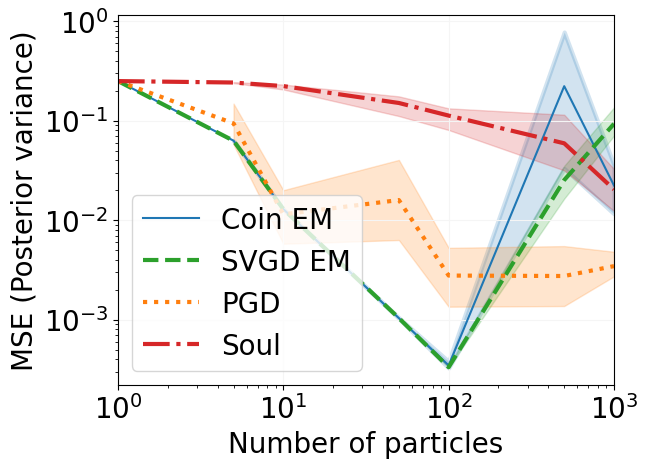

In [9]:
# compute confidence intervals


data_ada_pgd = (latent_var_pgd_all,)  # samples must be in a sequence
res_ada_pgd = bootstrap(data_ada_pgd, np.mean, confidence_level=0.9)

data_ada_svgd = (latent_var_svgd_all,) 
res_ada_svgd = bootstrap(data_ada_svgd, np.mean, confidence_level=0.9)

data_soul = (latent_var_soul_all,) 
res_soul = bootstrap(data_soul, np.mean, confidence_level=0.9)

data_coin = (latent_var_coin_all,) 
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

plt.plot(step_size_list, np.mean(latent_var_coin_all, 0), color="C0", label="Coin EM")
plt.fill_between(step_size_list, res_coin.confidence_interval[0], res_coin.confidence_interval[1], color="C0", alpha=0.2, linewidth=3)

plt.plot(step_size_list, np.mean(latent_var_svgd_all,0), color="C2", linestyle='dashed', label="SVGD EM", linewidth=3)
plt.fill_between(step_size_list, res_ada_svgd.confidence_interval[0], res_ada_svgd.confidence_interval[1], alpha=0.2, color="C2")

plt.plot(step_size_list, np.mean(latent_var_pgd_all,0), color="C1", linestyle='dotted', label="PGD", linewidth=3)
plt.fill_between(step_size_list, res_ada_pgd.confidence_interval[0], res_ada_pgd.confidence_interval[1], alpha=0.2, color="C1")

plt.plot(step_size_list, np.mean(latent_var_soul_all,0), color="C3", linestyle='dashdot', label="Soul", linewidth=3)
plt.fill_between(step_size_list, res_soul.confidence_interval[0], res_soul.confidence_interval[1], alpha=0.2, color="C3")

#plt.ylim(1e-16,10000)
plt.xscale("log")
plt.yscale("log") 
plt.legend(loc='lower left',prop={'size': 20})
plt.margins(x=0)
plt.xlabel("Number of particles", fontsize=20)
plt.ylabel(f"MSE (Posterior variance)", fontsize=20)
plt.grid(color='whitesmoke')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig(f"mse_latent_var_timed.pdf", bbox_inches='tight')


Using these results, we can compute an "optimal" step size for each method.

In [10]:
mse_ada_pgd = np.mean(mse_ada_pgd_all,axis=0) # mean over reps
mse_ada_svgd = np.mean(mse_ada_svgd_all,axis=0) # mean over reps
mse_soul = np.mean(mse_soul_all, axis=0) # mean over reps

lr_opt_ada_pgd_id = np.nanargmin(mse_ada_pgd)
lr_opt_ada_svgd_id = np.nanargmin(mse_ada_svgd)
lr_opt_soul_id = np.nanargmin(mse_soul)

# optimal LR
lr_opt_ada_pgd = step_size_list[lr_opt_ada_pgd_id]
lr_opt_ada_svgd = step_size_list[lr_opt_ada_svgd_id]
lr_opt_soul = step_size_list[lr_opt_soul_id]

# smaller LR
lr_small_ada_pgd = step_size_list[lr_opt_ada_pgd_id - 8]
lr_small_ada_svgd = step_size_list[lr_opt_ada_svgd_id - 8]
lr_small_soul = step_size_list[lr_opt_soul_id - 8]

# big LR 'at edge of stability'
lr_big_ada_pgd = step_size_list[np.isnan(mse_ada_pgd).argmax()] #step_size_list[lr_opt_ada_pgd_id + 1]
lr_big_ada_svgd = 1e2 #step_size_list[lr_opt_ada_svgd_id + 1]
lr_big_soul = step_size_list[np.isnan(mse_soul).argmax() - 1] #step_size_list[lr_opt_soul_id + 1]

print("Optimal LR (Adagrad-PGD): " + str(lr_opt_ada_pgd))
print("Optimal LR (Adagrad-SVGD): " + str(lr_opt_ada_svgd))
print("Optimal LR (SOUL): " + str(lr_opt_soul))

print("Small LR (Adagrad-PGD): " + str(lr_small_ada_pgd))
print("Small LR (Adagrad-SVGD): " + str(lr_small_ada_svgd))
print("Small LR (SOUL): " + str(lr_small_soul))

print("Big LR (Adagrad-PGD): " + str(lr_big_ada_pgd))
print("Big LR (Adagrad-SVGD): " + str(lr_big_ada_svgd))
print("Big LR (SOUL): " + str(lr_big_soul))

Optimal LR (Adagrad-PGD): 1000
Optimal LR (Adagrad-SVGD): 10
Optimal LR (SOUL): 1000
Small LR (Adagrad-PGD): 500
Small LR (Adagrad-SVGD): 5
Small LR (SOUL): 500
Big LR (Adagrad-PGD): 1
Big LR (Adagrad-SVGD): 100.0
Big LR (SOUL): 1000


We'll use these learning rates to run each method, now storing the results for all iterations.

In [11]:
# run all methods for the optimal step sizes
n_reps = 10

# Optimal LR
th_em_all, x_mean_em_all = np.zeros((n_reps, K)), np.zeros((n_reps, K, N, Dy))
th_ada_pgd_all, x_ada_pgd_all = np.zeros((n_reps, K)), np.zeros((n_reps, K, N, Dy))
th_ada_svgd_all, x_ada_svgd_all = np.zeros((n_reps, K)), np.zeros((n_reps, K, N, Dy))
th_soul_all, x_soul_all = np.zeros((n_reps, K)), np.zeros((n_reps, K, N, Dy))

mse_ada_pgd_all, mse_latent_ada_pgd_all = np.zeros((n_reps, K)), np.zeros((n_reps, K))
mse_ada_svgd_all, mse_latent_ada_svgd_all = np.zeros((n_reps, K)), np.zeros((n_reps, K))
mse_soul_all, mse_latent_soul_all = np.zeros((n_reps, K)), np.zeros((n_reps, K))
mse_coin_all, mse_latent_coin_all = np.zeros((n_reps, K)), np.zeros((n_reps, K))

# Small LR
th_ada_pgd_all_small, x_ada_pgd_all_small = np.zeros((n_reps, K)), np.zeros((n_reps, K, N, Dy))
th_ada_svgd_all_small, x_ada_svgd_all_small = np.zeros((n_reps, K)), np.zeros((n_reps, K, N, Dy))
th_soul_all_small, x_soul_all_small = np.zeros((n_reps, K)), np.zeros((n_reps, K, N, Dy))

mse_ada_pgd_all_small, mse_latent_ada_pgd_all_small = np.zeros((n_reps, K)), np.zeros((n_reps, K))
mse_ada_svgd_all_small, mse_latent_ada_svgd_all_small = np.zeros((n_reps, K)), np.zeros((n_reps, K))
mse_soul_all_small, mse_latent_soul_all_small = np.zeros((n_reps, K)), np.zeros((n_reps, K))
mse_coin_all_small, mse_latent_coin_all_small = np.zeros((n_reps, K)), np.zeros((n_reps, K))

# Big LR
th_ada_pgd_all_big, x_ada_pgd_all_big = np.zeros((n_reps, K)), np.zeros((n_reps, K, N, Dy))
th_ada_svgd_all_big, x_ada_svgd_all_big = np.zeros((n_reps, K)), np.zeros((n_reps, K, N, Dy))
th_soul_all_big, x_soul_all_big = np.zeros((n_reps, K)), np.zeros((n_reps, K, N, Dy))

mse_ada_pgd_all_big, mse_latent_ada_pgd_all_big = np.zeros((n_reps, K)), np.zeros((n_reps, K))
mse_ada_svgd_all_big, mse_latent_ada_svgd_all_big = np.zeros((n_reps, K)), np.zeros((n_reps, K))
mse_soul_all_big, mse_latent_soul_all_big = np.zeros((n_reps, K)), np.zeros((n_reps, K))
mse_coin_all_big, mse_latent_coin_all_big = np.zeros((n_reps, K)), np.zeros((n_reps, K))

# Coin 
th_coin_all, x_coin_all = np.zeros((n_reps, K)), np.zeros((n_reps, K, N, Dy))

# maximisers
theta_star_all = np.zeros((n_reps))
posterior_mean_empirical_all = np.zeros((n_reps, Dy))

for i, rep in enumerate(range(n_reps)):

    print("Repetition: " + str(i+1) + "/" + str(n_reps))

    # Setup Model
    key = jr.PRNGKey(int(i))
    Ny = 1
    Dy = 100

    theta = jnp.array([1.0])

    key_y, key_latent = jr.split(key)
    latent = theta + jr.normal(key_latent, (1, Dy))
    y = jr.normal(key_y, (Ny, Dy)) + latent

    theta_star = jnp.sum(y)/Dy
    theta_star_all[i] = theta_star

    posterior_mean = 0.5 * (y + theta*jnp.ones_like(y))
    posterior_mean_empirical = 0.5 * (y + theta_star * jnp.ones_like(y))

    posterior_mean_empirical_all[i, :] = posterior_mean_empirical
    
    th0 = .1*jr.normal(key, (1,))
    X0 = 1*jr.normal(key, (N, Dy)) 

    model = HierarchicalModel()
    data = Dataset(y=y)

    # EM
    th_em = em(model, data, th0, K)
    x_mean_em = (data.y.squeeze()  + th_em)
    th_em_all[i, :] = th_em.squeeze()

    # optimal LR
    x_ada_pgd, th_ada_pgd = ada_pgd(model, data, X0, th0, K, latent_step_size=lr_opt_ada_pgd, theta_step_size=lr_opt_ada_pgd)
    x_ada_svgd, th_ada_svgd = ada_svgd(model, data, X0, th0, K, theta_step_size=lr_opt_ada_svgd, latent_step_size=lr_opt_ada_svgd)
    x_soul, th_soul = soul(model, data, X0, th0, K, theta_step_size=lr_opt_soul, latent_step_size=lr_opt_soul)

    mse_ada_pgd = (th_ada_pgd - theta_star)**2
    mse_ada_svgd = (th_ada_svgd - theta_star)**2
    mse_soul = (th_soul - theta_star)**2

    mse_latent_ada_pgd = ((x_ada_pgd.mean(axis=1) - posterior_mean_empirical[:,np.newaxis])**2).mean(axis=2)
    mse_latent_ada_svgd = ((x_ada_svgd.mean(axis=1) - posterior_mean_empirical[:,np.newaxis])**2).mean(axis=2)
    mse_latent_soul = ((x_soul.mean(axis=1) - posterior_mean_empirical[:,np.newaxis])**2).mean(axis=2)

    x_ada_pgd_all[i, :, :, :], th_ada_pgd_all[i, :] = x_ada_pgd, th_ada_pgd.squeeze()
    x_ada_svgd_all[i, :, :, :], th_ada_svgd_all[i, :] = x_ada_svgd, th_ada_svgd.squeeze()
    x_soul_all[i, :, :, :], th_soul_all[i, :] = x_soul, th_soul.squeeze()

    mse_ada_pgd_all[i,:] = mse_ada_pgd.squeeze()
    mse_ada_svgd_all[i,:] = mse_ada_svgd.squeeze()
    mse_soul_all[i,:] = mse_soul.squeeze()

    mse_latent_ada_pgd_all[i,:] = mse_latent_ada_pgd.squeeze()
    mse_latent_ada_svgd_all[i,:] = mse_latent_ada_svgd.squeeze()
    mse_latent_soul_all[i,:] = mse_latent_soul.squeeze()

    # small LR
    x_ada_pgd_small, th_ada_pgd_small = ada_pgd(model, data, X0, th0, K, latent_step_size=lr_small_ada_pgd, theta_step_size=lr_small_ada_pgd)
    x_ada_svgd_small, th_ada_svgd_small = ada_svgd(model, data, X0, th0, K, theta_step_size=lr_small_ada_svgd, latent_step_size=lr_small_ada_svgd)
    x_soul_small, th_soul_small = soul(model, data, X0, th0, K, theta_step_size=lr_small_soul, latent_step_size=lr_small_soul)

    mse_ada_pgd_small = (th_ada_pgd_small - theta_star)**2
    mse_ada_svgd_small = (th_ada_svgd_small - theta_star)**2
    mse_soul_small = (th_soul_small - theta_star)**2

    mse_latent_ada_pgd_small = ((x_ada_pgd_small.mean(axis=1) - posterior_mean_empirical[:,np.newaxis])**2).mean(axis=2)
    mse_latent_ada_svgd_small = ((x_ada_svgd_small.mean(axis=1) - posterior_mean_empirical[:,np.newaxis])**2).mean(axis=2)
    mse_latent_soul_small = ((x_soul_small.mean(axis=1) - posterior_mean_empirical[:,np.newaxis])**2).mean(axis=2)

    x_ada_pgd_all_small[i, :, :, :], th_ada_pgd_all_small[i, :] = x_ada_pgd_small, th_ada_pgd_small.squeeze()
    x_ada_svgd_all_small[i, :, :, :], th_ada_svgd_all_small[i, :] = x_ada_svgd_small, th_ada_svgd_small.squeeze()
    x_soul_all_small[i, :, :, :], th_soul_all_small[i, :] = x_soul_small, th_soul_small.squeeze()

    mse_ada_pgd_all_small[i,:] = mse_ada_pgd_small.squeeze()
    mse_ada_svgd_all_small[i,:] = mse_ada_svgd_small.squeeze()
    mse_soul_all_small[i,:] = mse_soul_small.squeeze()

    mse_latent_ada_pgd_all_small[i,:] = mse_latent_ada_pgd_small.squeeze()
    mse_latent_ada_svgd_all_small[i,:] = mse_latent_ada_svgd_small.squeeze()
    mse_latent_soul_all_small[i,:] = mse_latent_soul_small.squeeze()

    # big LR
    x_ada_pgd_big, th_ada_pgd_big = ada_pgd(model, data, X0, th0, K, latent_step_size=lr_big_ada_pgd, theta_step_size=lr_big_ada_pgd)
    x_ada_svgd_big, th_ada_svgd_big = ada_svgd(model, data, X0, th0, K, theta_step_size=lr_big_ada_svgd, latent_step_size=lr_big_ada_svgd)
    x_soul_big, th_soul_big = soul(model, data, X0, th0, K, theta_step_size=lr_big_soul, latent_step_size=lr_big_soul)

    mse_ada_pgd_big = (th_ada_pgd_big - theta_star)**2
    mse_ada_svgd_big = (th_ada_svgd_big - theta_star)**2
    mse_soul_big = (th_soul_big - theta_star)**2

    mse_latent_ada_pgd_big = ((x_ada_pgd_big.mean(axis=1) - posterior_mean_empirical[:,np.newaxis])**2).mean(axis=2)
    mse_latent_ada_svgd_big = ((x_ada_svgd_big.mean(axis=1) - posterior_mean_empirical[:,np.newaxis])**2).mean(axis=2)
    mse_latent_soul_big = ((x_soul_big.mean(axis=1) - posterior_mean_empirical[:,np.newaxis])**2).mean(axis=2)

    x_ada_pgd_all_big[i, :, :, :], th_ada_pgd_all_big[i, :] = x_ada_pgd_big, th_ada_pgd_big.squeeze()
    x_ada_svgd_all_big[i, :, :, :], th_ada_svgd_all_big[i, :] = x_ada_svgd_big, th_ada_svgd_big.squeeze()
    x_soul_all_big[i, :, :, :], th_soul_all_big[i, :] = x_soul_big, th_soul_big.squeeze()

    mse_ada_pgd_all_big[i,:] = mse_ada_pgd_big.squeeze()
    mse_ada_svgd_all_big[i,:] = mse_ada_svgd_big.squeeze()
    mse_soul_all_big[i,:] = mse_soul_big.squeeze()

    mse_latent_ada_pgd_all_big[i,:] = mse_latent_ada_pgd_big.squeeze()
    mse_latent_ada_svgd_all_big[i,:] = mse_latent_ada_svgd_big.squeeze()
    mse_latent_soul_all_big[i,:] = mse_latent_soul_big.squeeze()

    # coin 
    x_coin, th_coin = coin_svgd(model, data, X0, th0, K)
    mse_coin = (th_coin - theta_star) ** 2
    mse_latent_coin = ((x_coin.mean(axis=1) - posterior_mean_empirical[:,np.newaxis])**2).mean(axis=2)
    x_coin_all[i, :, :, :], th_coin_all[i, :] = x_coin, th_coin.squeeze()
    mse_coin_all[i, :] = mse_coin.squeeze()
    mse_latent_coin_all[i,:] = mse_latent_coin.squeeze()    

TypeError: 'float' object cannot be interpreted as an integer

### (b) MSE vs Iterations (Theta)  [Fig. 1(b), Fig. 6(b), Fig. 7(b), Fig. 9(b)]

We now plot MSE vs iterations, using the optimal LR.

In [ ]:
# Plot MSE (theta) vs iterations

mse_coin = np.mean(mse_coin_all, axis=0)
mse_ada_pgd = np.mean(mse_ada_pgd_all,axis=0) # mean over reps
mse_ada_svgd = np.mean(mse_ada_svgd_all,axis=0) # mean over reps
mse_soul = np.mean(mse_soul_all, axis=0) # mean over reps

# compute confidence intervals

data_ada_pgd = (mse_ada_pgd_all,)  # samples must be in a sequence
res_ada_pgd = bootstrap(data_ada_pgd, np.mean, confidence_level=0.9)

data_ada_svgd = (mse_ada_svgd_all,)  # samples must be in a sequence
res_ada_svgd = bootstrap(data_ada_svgd, np.mean, confidence_level=0.9)

data_soul = (mse_soul_all,)  # samples must be in a sequence
res_soul = bootstrap(data_soul, np.mean, confidence_level=0.9, n_resamples=100)

data_coin = (mse_coin_all,)  # samples must be in a sequence
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

plt.plot(range(K), mse_coin, color="C0", zorder=10, label="Coin EM", linewidth=3)
plt.fill_between(range(K), res_coin.confidence_interval[0], res_coin.confidence_interval[1], color="C0", alpha=0.2, linewidth=2)

plt.plot(range(K), mse_ada_svgd, zorder=8, color="C2", label="SVGD EM", linestyle="dashed", linewidth=3)
plt.fill_between(range(K), res_ada_svgd.confidence_interval[0], res_ada_svgd.confidence_interval[1], color="C2", alpha=0.2)

plt.plot(range(K), mse_ada_pgd, color="C1", label="PGD", linestyle="dotted", linewidth=3)
plt.fill_between(range(K), res_ada_pgd.confidence_interval[0], res_ada_pgd.confidence_interval[1], color="C1", alpha=0.2)

plt.plot(range(K), mse_soul, color="C3", label="SOUL", linestyle='dashdot', linewidth=3)
plt.fill_between(range(K), res_soul.confidence_interval[0], res_soul.confidence_interval[1], color="C3", alpha=0.2)

plt.legend(loc='upper right',prop={'size': 20})
plt.xlabel('Iteration', fontsize=20)
plt.ylabel("MSE (Theta Estimate)", fontsize=20)
plt.yscale("log")
plt.ylim(1e-16,10e1)
plt.grid(color='whitesmoke')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

### (c) MSE vs Iterations (Latent)  [Fig. 1(c), Fig. 6(c), Fig. 7(c), Fig. 9(c)]

Finally, we plot the MSE of the posterior mean vs the iterations.

In [ ]:
# Plot MSE (theta) vs iterations

mse_latent_coin = np.mean(mse_latent_coin_all, axis=0)
mse_latent_ada_pgd = np.mean(mse_latent_ada_pgd_all,axis=0) # mean over reps
mse_latent_ada_svgd = np.mean(mse_latent_ada_svgd_all,axis=0) # mean over reps
mse_latent_soul = np.mean(mse_latent_soul_all, axis=0) # mean over reps

# compute confidence intervals

data_ada_pgd = (mse_latent_ada_pgd_all,)  # samples must be in a sequence
res_ada_pgd = bootstrap(data_ada_pgd, np.mean, confidence_level=0.9)

data_ada_svgd = (mse_latent_ada_svgd_all,)  # samples must be in a sequence
res_ada_svgd = bootstrap(data_ada_svgd, np.mean, confidence_level=0.9)

data_soul = (mse_latent_soul_all,)  # samples must be in a sequence
res_soul = bootstrap(data_soul, np.mean, confidence_level=0.9, n_resamples=100)

data_coin = (mse_latent_coin_all,)  # samples must be in a sequence
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

plt.plot(range(K), mse_latent_coin, color="C0", zorder=10, label="Coin EM", linewidth=3)
plt.fill_between(range(K), res_coin.confidence_interval[0], res_coin.confidence_interval[1], color="C0", alpha=0.2, linewidth=2)

plt.plot(range(K), mse_latent_ada_svgd, zorder=8, color="C2", label="SVGD EM", linestyle="dashed", linewidth=3)
plt.fill_between(range(K), res_ada_svgd.confidence_interval[0], res_ada_svgd.confidence_interval[1], color="C2", alpha=0.2)

plt.plot(range(K), mse_latent_ada_pgd, color="C1", label="PGD", linestyle="dotted", linewidth=3)
plt.fill_between(range(K), res_ada_pgd.confidence_interval[0], res_ada_pgd.confidence_interval[1], color="C1", alpha=0.2)

plt.plot(range(K), mse_latent_soul, color="C3", label="SOUL", linestyle='dashdot', linewidth=3)
plt.fill_between(range(K), res_soul.confidence_interval[0], res_soul.confidence_interval[1], color="C3", alpha=0.2)

plt.legend(loc='upper right',prop={'size': 20})
plt.xlabel('Iteration', fontsize=20)
plt.ylabel("MSE (Posterior Mean)", fontsize=20)
plt.yscale("log")
plt.ylim(1e-15,10e1)
plt.grid(color='whitesmoke')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

### (d) SVGD EM vs Coin EM (Different LRs) [Fig. 8(a)]

We can also perform a closer pairwise comparison between each method and Coin EM. Here, we take a closer look at SVGD EM. We plot the parameter MSE, the parameter estimates, and the posterior mean MSE, for three different choices of the learning rate: the optimal LR from before, a smaller LR, and a larger LR. 

In [ ]:
# Plot MSE (theta) vs iterations

mse_coin = np.mean(mse_coin_all, axis=0)
mse_ada_svgd = np.mean(mse_ada_svgd_all,axis=0) # mean over reps
mse_ada_svgd_small = np.mean(mse_ada_svgd_all_small,axis=0) # mean over reps
mse_ada_svgd_big = np.mean(mse_ada_svgd_all_big,axis=0) # mean over reps

# compute confidence intervals

data_ada_svgd = (mse_ada_svgd_all,)  # samples must be in a sequence
res_ada_svgd = bootstrap(data_ada_svgd, np.mean, confidence_level=0.9)

data_ada_svgd_small = (mse_ada_svgd_all_small,)  # samples must be in a sequence
res_ada_svgd_small = bootstrap(data_ada_svgd_small, np.mean, confidence_level=0.9)

data_ada_svgd_big = (mse_ada_svgd_all_big,)  # samples must be in a sequence
res_ada_svgd_big = bootstrap(data_ada_svgd_big, np.mean, confidence_level=0.9)

data_coin = (mse_coin_all,)  # samples must be in a sequence
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

plt.plot(range(K), mse_coin, color="C0", zorder=10, label="Coin EM", linewidth=3)
plt.fill_between(range(K), res_coin.confidence_interval[0], res_coin.confidence_interval[1], color="C0", alpha=0.2, linewidth=2)

plt.plot(range(K), mse_ada_svgd, zorder=8, color="C2", label="SVGD EM (Optimal LR)", linestyle="dashed", linewidth=3)
plt.fill_between(range(K), res_ada_svgd.confidence_interval[0], res_ada_svgd.confidence_interval[1], color="C2", alpha=0.2)

plt.plot(range(K), mse_ada_svgd_small, color="C1", label="SVGD EM (Small LR)", linestyle="dotted", linewidth=3)
plt.fill_between(range(K), res_ada_svgd_small.confidence_interval[0], res_ada_svgd_small.confidence_interval[1], color="C1", alpha=0.2)

plt.plot(range(K), mse_ada_svgd_big, color="C3", label="SVGD EM (Big LR)", linestyle='dashdot', linewidth=3)
plt.fill_between(range(K), res_ada_svgd_big.confidence_interval[0], res_ada_svgd_big.confidence_interval[1], color="C3", alpha=0.2)

plt.legend(loc='upper right',prop={'size': 16})
plt.xlabel('Iteration', fontsize=16)
plt.ylabel("MSE (Theta Estimate)", fontsize=16)
plt.yscale("log")
plt.ylim(1e-16,10e2)
plt.grid(color='whitesmoke')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()




# Plot MSE (latent) vs iterations

mse_latent_coin = np.mean(mse_latent_coin_all, axis=0)
mse_latent_ada_svgd = np.mean(mse_latent_ada_svgd_all,axis=0) # mean over reps
mse_latent_ada_svgd_small = np.mean(mse_latent_ada_svgd_all_small,axis=0) # mean over reps
mse_latent_ada_svgd_big = np.mean(mse_latent_ada_svgd_all_big,axis=0) # mean over reps

# compute confidence intervals

data_ada_svgd = (mse_latent_ada_svgd_all,)  # samples must be in a sequence
res_ada_svgd = bootstrap(data_ada_svgd, np.mean, confidence_level=0.9)

data_ada_svgd_small = (mse_latent_ada_svgd_all_small,)  # samples must be in a sequence
res_ada_svgd_small = bootstrap(data_ada_svgd_small, np.mean, confidence_level=0.9)

data_ada_svgd_big = (mse_latent_ada_svgd_all_big,)  # samples must be in a sequence
res_ada_svgd_big = bootstrap(data_ada_svgd_big, np.mean, confidence_level=0.9)

data_coin = (mse_latent_coin_all,)  # samples must be in a sequence
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

plt.plot(range(K), mse_latent_coin, color="C0", zorder=10, label="Coin EM", linewidth=3)
plt.fill_between(range(K), res_coin.confidence_interval[0], res_coin.confidence_interval[1], color="C0", alpha=0.2, linewidth=2)

plt.plot(range(K), mse_latent_ada_svgd, zorder=8, color="C2", label="SVGD EM (Optimal LR)", linestyle="dashed", linewidth=3)
plt.fill_between(range(K), res_ada_svgd.confidence_interval[0], res_ada_svgd.confidence_interval[1], color="C2", alpha=0.2)

plt.plot(range(K), mse_latent_ada_svgd_small, color="C1", label="SVGD EM (Small LR)", linestyle="dotted", linewidth=3)
plt.fill_between(range(K), res_ada_svgd_small.confidence_interval[0], res_ada_svgd_small.confidence_interval[1], color="C1", alpha=0.2)

plt.plot(range(K), mse_latent_ada_svgd_big, color="C3", label="SVGD EM (Big LR)", linestyle='dashdot', linewidth=3)
plt.fill_between(range(K), res_ada_svgd_big.confidence_interval[0], res_ada_svgd_big.confidence_interval[1], color="C3", alpha=0.2)

plt.legend(loc='upper right',prop={'size': 16})
plt.xlabel('Iteration', fontsize=16)
plt.ylabel("MSE (Latent Estimate)", fontsize=16)
plt.yscale("log")
plt.ylim(1e-16,10e2)
plt.grid(color='whitesmoke')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()



# Plot theta vs iterations (illustrative run)
which_rep = 6
th_coin = th_coin_all[which_rep,:]
th_svgd = th_ada_svgd_all[which_rep,:]
th_svgd_small = th_ada_svgd_all_small[which_rep,:]
th_svgd_big = th_ada_svgd_all_big[which_rep,:]

# compute confidence intervals
data_ada_svgd = (th_ada_svgd_all,)  # samples must be in a sequence
res_ada_svgd = bootstrap(data_ada_svgd, np.mean, confidence_level=0.9)

data_ada_svgd_small = (th_ada_svgd_all_small,)  # samples must be in a sequence
res_ada_svgd_small = bootstrap(data_ada_svgd_small, np.mean, confidence_level=0.9)

data_ada_svgd_big = (th_ada_svgd_all_big,)  # samples must be in a sequence
res_ada_svgd_big = bootstrap(data_ada_svgd_big, np.mean, confidence_level=0.9)

data_coin = (th_coin_all,)  # samples must be in a sequence
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

plt.plot(range(K), th_coin, color="C0", zorder=10, label="Coin EM", linewidth=3)
plt.plot(range(K), th_svgd, zorder=8, color="C2", label="SVGD EM (Optimal LR)", linestyle="dashed", linewidth=3)
plt.plot(range(K), th_svgd_small, color="C1", label="SVGD EM (Small LR)", linestyle="dotted", linewidth=3)
plt.plot(range(K), th_svgd_big, color="C3", label="SVGD EM (Big LR)", linestyle='dashdot', linewidth=3)

plt.legend(loc='upper right',prop={'size': 16})
plt.xlabel('Iteration', fontsize=16)
plt.ylabel("Theta", fontsize=16)
plt.axhline(theta_star_all[which_rep], color="black", linewidth=3, zorder=2)
plt.xlim([-1,100]) # just plot first 100 iterations
plt.ylim(-1,3)
plt.grid(color='whitesmoke')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

### (e) PGD vs Coin EM (Different LRs) [Fig. 8(b)]

We can repeat the same plots for PGD. Once again, we plot the parameter MSE, the parameter estimates, and the posterior mean MSE, for three different choices of the learning rate: the optimal LR from before, a smaller LR, and a larger LR.

In [ ]:
# Plot MSE (theta) vs iterations

mse_coin = np.mean(mse_coin_all, axis=0)
mse_ada_pgd = np.mean(mse_ada_pgd_all,axis=0) # mean over reps
mse_ada_pgd_small = np.mean(mse_ada_pgd_all_small,axis=0) # mean over reps
mse_ada_pgd_big = np.mean(mse_ada_pgd_all_big,axis=0) # mean over reps

# compute confidence intervals

data_ada_pgd = (mse_ada_pgd_all,)  # samples must be in a sequence
res_ada_pgd = bootstrap(data_ada_pgd, np.mean, confidence_level=0.9)

data_ada_pgd_small = (mse_ada_pgd_all_small,)  # samples must be in a sequence
res_ada_pgd_small = bootstrap(data_ada_pgd_small, np.mean, confidence_level=0.9)

data_ada_pgd_big = (mse_ada_pgd_all_big,)  # samples must be in a sequence
res_ada_pgd_big = bootstrap(data_ada_pgd_big, np.mean, confidence_level=0.9)

data_coin = (mse_coin_all,)  # samples must be in a sequence
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

plt.plot(range(K), mse_coin, color="C0", zorder=10, label="Coin EM", linewidth=3)
plt.fill_between(range(K), res_coin.confidence_interval[0], res_coin.confidence_interval[1], color="C0", alpha=0.2, linewidth=2)

plt.plot(range(K), mse_ada_pgd, zorder=8, color="C2", label="PGD (Optimal LR)", linestyle="dashed", linewidth=3)
plt.fill_between(range(K), res_ada_pgd.confidence_interval[0], res_ada_pgd.confidence_interval[1], color="C2", alpha=0.2)

plt.plot(range(K), mse_ada_pgd_small, color="C1", label="PGD (Small LR)", linestyle="dotted", linewidth=3)
plt.fill_between(range(K), res_ada_pgd_small.confidence_interval[0], res_ada_pgd_small.confidence_interval[1], color="C1", alpha=0.2)

plt.plot(range(K), mse_ada_pgd_big, color="C3", label="PGD (Big LR)", linestyle='dashdot', linewidth=3)
plt.fill_between(range(K), res_ada_pgd_big.confidence_interval[0], res_ada_pgd_big.confidence_interval[1], color="C3", alpha=0.2)

plt.legend(loc='upper right',prop={'size': 16})
plt.xlabel('Iteration', fontsize=16)
plt.ylabel("MSE (Theta Estimate)", fontsize=16)
plt.yscale("log")
plt.ylim(1e-16,10e2)
plt.grid(color='whitesmoke')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()


# Plot MSE (latent) vs iterations

mse_latent_coin = np.mean(mse_latent_coin_all, axis=0)
mse_latent_ada_pgd = np.mean(mse_latent_ada_pgd_all,axis=0) # mean over reps
mse_latent_ada_pgd_small = np.mean(mse_latent_ada_pgd_all_small,axis=0) # mean over reps
mse_latent_ada_pgd_big = np.mean(mse_latent_ada_pgd_all_big,axis=0) # mean over reps

# compute confidence intervals

data_ada_pgd = (mse_latent_ada_pgd_all,)  # samples must be in a sequence
res_ada_pgd = bootstrap(data_ada_pgd, np.mean, confidence_level=0.9)

data_ada_pgd_small = (mse_latent_ada_pgd_all_small,)  # samples must be in a sequence
res_ada_pgd_small = bootstrap(data_ada_pgd_small, np.mean, confidence_level=0.9)

data_ada_pgd_big = (mse_latent_ada_pgd_all_big,)  # samples must be in a sequence
res_ada_pgd_big = bootstrap(data_ada_pgd_big, np.mean, confidence_level=0.9)

data_coin = (mse_latent_coin_all,)  # samples must be in a sequence
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

plt.plot(range(K), mse_latent_coin, color="C0", zorder=10, label="Coin EM", linewidth=3)
plt.fill_between(range(K), res_coin.confidence_interval[0], res_coin.confidence_interval[1], color="C0", alpha=0.2, linewidth=2)

plt.plot(range(K), mse_latent_ada_pgd, zorder=8, color="C2", label="PGD (Optimal LR)", linestyle="dashed", linewidth=3)
plt.fill_between(range(K), res_ada_pgd.confidence_interval[0], res_ada_pgd.confidence_interval[1], color="C2", alpha=0.2)

plt.plot(range(K), mse_latent_ada_pgd_small, color="C1", label="PGD (Small LR)", linestyle="dotted", linewidth=3)
plt.fill_between(range(K), res_ada_pgd_small.confidence_interval[0], res_ada_pgd_small.confidence_interval[1], color="C1", alpha=0.2)

plt.plot(range(K), mse_latent_ada_pgd_big, color="C3", label="PGD (Big LR)", linestyle='dashdot', linewidth=3)
plt.fill_between(range(K), res_ada_pgd_big.confidence_interval[0], res_ada_pgd_big.confidence_interval[1], color="C3", alpha=0.2)

plt.legend(loc='upper right',prop={'size': 16})
plt.xlabel('Iteration', fontsize=16)
plt.ylabel("MSE (Latent Estimate)", fontsize=16)
plt.yscale("log")
plt.ylim(1e-16,10e2)
plt.grid(color='whitesmoke')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()




# Plot theta vs iterations (illustrative run)
which_rep = 6
th_coin = th_coin_all[which_rep,:]
th_pgd = th_ada_pgd_all[which_rep,:]
th_pgd_small = th_ada_pgd_all_small[which_rep,:]
th_pgd_big = th_ada_pgd_all_big[which_rep,:]

# compute confidence intervals

data_ada_pgd = (th_ada_pgd_all,)  # samples must be in a sequence
res_ada_pgd = bootstrap(data_ada_pgd, np.mean, confidence_level=0.9)

data_ada_pgd_small = (th_ada_pgd_all_small,)  # samples must be in a sequence
res_ada_pgd_small = bootstrap(data_ada_pgd_small, np.mean, confidence_level=0.9)

data_ada_pgd_big = (th_ada_pgd_all_big,)  # samples must be in a sequence
res_ada_pgd_big = bootstrap(data_ada_pgd_big, np.mean, confidence_level=0.9)

data_coin = (th_coin_all,)  # samples must be in a sequence
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

plt.plot(range(K), th_coin, color="C0", zorder=10, label="Coin EM", linewidth=3)
plt.plot(range(K), th_pgd, zorder=8, color="C2", label="PGD (Optimal LR)", linestyle="dashed", linewidth=3)
plt.plot(range(K), th_pgd_small, color="C1", label="PGD (Small LR)", linestyle="dotted", linewidth=3)
plt.plot(range(K), th_pgd_big, color="C3", label="PGD (Big LR)", linestyle='dashdot', linewidth=3)

plt.legend(loc='upper right',prop={'size': 16})
plt.xlabel('Iteration', fontsize=16)
plt.ylabel("Theta", fontsize=16)
plt.axhline(theta_star_all[which_rep], color="black", linewidth=3, zorder=2)
plt.xlim([-1,100]) # just plot first 100 iterations
plt.ylim(-.5,2)
plt.grid(color='whitesmoke')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

### (f) SOUL vs Coin EM (Different LRs) [Fig. 8(c)]

Finally, we recreate these plots for SOUL. Once again, we plot the parameter MSE, the parameter estimates, and the posterior mean MSE, for three different choices of the learning rate: the optimal LR from before, a smaller LR, and a larger LR.

In [ ]:
# Plot MSE (theta) vs iterations

mse_coin = np.mean(mse_coin_all, axis=0)
mse_soul = np.mean(mse_soul_all,axis=0) # mean over reps
mse_soul_small = np.mean(mse_soul_all_small,axis=0) # mean over reps
mse_soul_big = np.mean(mse_soul_all_big,axis=0) # mean over reps

# compute confidence intervals

data_soul = (mse_soul_all,)  # samples must be in a sequence
res_soul = bootstrap(data_soul, np.mean, confidence_level=0.9)

data_soul_small = (mse_soul_all_small,)  # samples must be in a sequence
res_soul_small = bootstrap(data_soul_small, np.mean, confidence_level=0.9)

data_soul_big = (mse_soul_all_big,)  # samples must be in a sequence
res_soul_big = bootstrap(data_soul_big, np.mean, confidence_level=0.9)

data_coin = (mse_coin_all,)  # samples must be in a sequence
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

plt.plot(range(K), mse_coin, color="C0", zorder=10, label="Coin EM", linewidth=3)
plt.fill_between(range(K), res_coin.confidence_interval[0], res_coin.confidence_interval[1], color="C0", alpha=0.2, linewidth=2)

plt.plot(range(K), mse_soul, zorder=8, color="C2", label="SOUL (Optimal LR)", linestyle="dashed", linewidth=3)
plt.fill_between(range(K), res_soul.confidence_interval[0], res_soul.confidence_interval[1], color="C2", alpha=0.2)

plt.plot(range(K), mse_soul_small, color="C1", label="SOUL (Small LR)", linestyle="dotted", linewidth=3)
plt.fill_between(range(K), res_soul_small.confidence_interval[0], res_soul_small.confidence_interval[1], color="C1", alpha=0.2)

plt.plot(range(K), mse_soul_big, color="C3", label="SOUL (Big LR)", linestyle='dashdot', linewidth=3)
plt.fill_between(range(K), res_soul_big.confidence_interval[0], res_soul_big.confidence_interval[1], color="C3", alpha=0.2)

plt.legend(loc='upper right',prop={'size': 16})
plt.xlabel('Iteration', fontsize=16)
plt.ylabel("MSE (Theta Estimate)", fontsize=16)
plt.yscale("log")
plt.ylim(1e-16,10e2)
plt.grid(color='whitesmoke')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()



# Plot MSE (latent) vs iterations

mse_latent_coin = np.mean(mse_latent_coin_all, axis=0)
mse_latent_soul = np.mean(mse_latent_soul_all,axis=0) # mean over reps
mse_latent_soul_small = np.mean(mse_latent_soul_all_small,axis=0) # mean over reps
mse_latent_soul_big = np.mean(mse_latent_soul_all_big,axis=0) # mean over reps

# compute confidence intervals

data_soul = (mse_latent_soul_all,)  # samples must be in a sequence
res_soul = bootstrap(data_soul, np.mean, confidence_level=0.9)

data_soul_small = (mse_latent_soul_all_small,)  # samples must be in a sequence
res_soul_small = bootstrap(data_soul_small, np.mean, confidence_level=0.9)

data_soul_big = (mse_latent_soul_all_big,)  # samples must be in a sequence
res_soul_big = bootstrap(data_soul_big, np.mean, confidence_level=0.9)

data_coin = (mse_latent_coin_all,)  # samples must be in a sequence
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

plt.plot(range(K), mse_latent_coin, color="C0", zorder=10, label="Coin EM", linewidth=3)
plt.fill_between(range(K), res_coin.confidence_interval[0], res_coin.confidence_interval[1], color="C0", alpha=0.2, linewidth=2)

plt.plot(range(K), mse_latent_soul, zorder=8, color="C2", label="SOUL (Optimal LR)", linestyle="dashed", linewidth=3)
plt.fill_between(range(K), res_soul.confidence_interval[0], res_soul.confidence_interval[1], color="C2", alpha=0.2)

plt.plot(range(K), mse_latent_soul_small, color="C1", label="SOUL (Small LR)", linestyle="dotted", linewidth=3)
plt.fill_between(range(K), res_soul_small.confidence_interval[0], res_soul_small.confidence_interval[1], color="C1", alpha=0.2)

plt.plot(range(K), mse_latent_soul_big, color="C3", label="PGD (Big LR)", linestyle='dashdot', linewidth=3)
plt.fill_between(range(K), res_soul_big.confidence_interval[0], res_soul_big.confidence_interval[1], color="C3", alpha=0.2)

plt.legend(loc='upper right',prop={'size': 16})
plt.xlabel('Iteration', fontsize=16)
plt.ylabel("MSE (Latent Estimate)", fontsize=16)
plt.yscale("log")
plt.ylim(1e-16,10e2)
plt.grid(color='whitesmoke')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()



# Plot theta vs iterations (illustrative run)

th_coin = th_coin_all[which_rep,:]
th_soul = th_soul_all[which_rep,:]
th_soul_small = th_soul_all_small[which_rep,:]
th_soul_big = th_soul_all_big[which_rep,:]

# compute confidence intervals

data_soul = (th_ada_pgd_all,)  # samples must be in a sequence
res_soul = bootstrap(data_soul, np.mean, confidence_level=0.9)

data_soul_small = (th_ada_pgd_all_small,)  # samples must be in a sequence
res_soul_small = bootstrap(data_soul_small, np.mean, confidence_level=0.9)

data_ada_pgd_big = (th_ada_pgd_all_big,)  # samples must be in a sequence
res_ada_pgd_big = bootstrap(data_soul_big, np.mean, confidence_level=0.9)

data_coin = (th_coin_all,)  # samples must be in a sequence
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

plt.plot(range(K), th_coin, color="C0", zorder=10, label="Coin EM", linewidth=3)
plt.plot(range(K), th_soul, zorder=8, color="C2", label="SOUL (Optimal LR)", linestyle="dashed", linewidth=3)
plt.plot(range(K), th_soul_small, color="C1", label="SOUL (Small LR)", linestyle="dotted", linewidth=3)
plt.plot(range(K), th_soul_big, color="C3", label="SOUL (Big LR)", linestyle='dashdot', linewidth=3)

plt.legend(loc='upper right',prop={'size': 16})
plt.xlabel('Iteration', fontsize=16)
plt.ylabel("Theta", fontsize=16)
plt.axhline(theta_star_all[which_rep], color="black", linewidth=3, zorder=2)
plt.xlim([-1,100]) # just plot first 100 iterations
plt.ylim(-5,6)
plt.grid(color='whitesmoke')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

# Experiment 2: Posterior Variance

We now consider a single latent dimension. In this case, the optimal posterior variance is just given by 1/2. We start by running some repeats for Coin SVGD, EM SVGD, and PGD.

In [ ]:
from coinem.zoo import coin_svgd, ada_svgd, soul, pgd, ada_pgd, standard_svgd
from coinem.marginal_zoo import marginal_coin_svgd, marginal_ada_svgd, marginal_soul, marginal_pgd
    
K = 5000  # Number of steps.

Ny = 1
Dy = 1
key = jr.PRNGKey(42)
theta = jnp.array([1.0])

key_y, key_latent = jr.split(key)
latent = theta + jr.normal(key_latent, (1, Dy))
y = jr.normal(key_y, (Ny, Dy)) + latent

data = Dataset(y=y)

reps = 10
N_list = [2, 5, 10, 20, 50, 100]
    
x_coin_all_list, th_coin_all_list = [], []
x_svgd_all_list, th_svgd_all_list = [], []
x_pgd_all_list, th_pgd_all_list = [], []

for i, N in enumerate(N_list):

    print("N value: " + str(i+1) + "/" + str(len(N_list)))

    x_coin_all, th_coin_all = np.zeros((reps, K, N, Dy)), np.zeros((reps, K))
    x_svgd_all, th_svgd_all = np.zeros((reps, K, N, Dy)), np.zeros((reps, K))
    x_pgd_all, th_pgd_all = np.zeros((reps, K, N, Dy)), np.zeros((reps, K))

    for j, rep in enumerate(range(reps)):

        print("Repetition: " + str(j+1) + "/" + str(reps))

        key, subkey = jr.split(key)
        th0 = 1 + jr.normal(subkey, (1,)) # initial parameter guess.
        X0 = jr.normal(subkey, (N, Dy))  # initial particle cloud.

        model = HierarchicalModel()

        # Run methods
        x_coin, th_coin = coin_svgd(model, data, X0, th0, K) 
        x_svgd, th_svgd = ada_svgd(model, data, X0, th0, K, latent_step_size=1, theta_step_size=1)
        x_pgd, th_pgd = ada_pgd(model, data, X0, th0, K)

        x_coin_all[j, :, :], th_coin_all[j, :] = x_coin, th_coin.squeeze()
        x_svgd_all[j, :, :], th_svgd_all[j, :] = x_svgd, th_svgd.squeeze()
        x_pgd_all[j, :, :], th_pgd_all[j, :] = x_pgd, th_pgd.squeeze()

    x_coin_all_list.append(x_coin_all)
    th_coin_all_list.append(th_coin_all)

    x_svgd_all_list.append(x_svgd_all)
    th_svgd_all_list.append(th_svgd_all)

    x_pgd_all_list.append(x_pgd_all)
    th_pgd_all_list.append(th_pgd_all)

### (a)(i) Posterior Variance vs Iterations

Let's plot the results. First we'll compute the variance by averaging over time and over the particles. It seems coin tends to underestimate the variance, for smaller numbers of particles.

In [ ]:
import copy
    
fig1, ax1 = plt.subplots(1, figsize=(5,4))
fig2, ax2 = plt.subplots(1, figsize=(5,4))
fig3, ax3 = plt.subplots(1, figsize=(5,4))

for i, N in enumerate(N_list):
    
    x_coin_all = x_coin_all_list[i]
    x_svgd_all = x_svgd_all_list[i]
    x_pgd_all = x_pgd_all_list[i]    
    
    #mu1_coin = x_coin_all.mean(axis=2) ** 2 # E[x]^2, expectation over particles
    mu1_coin = x_coin_all.mean(axis=2)
    mu2_coin = (x_coin_all ** 2).mean(axis=2) # E[x^2], expectation over particles
    #var_coin = (mu2_coin - mu1_coin).squeeze() # Var(x)
    var_coin = ((jnp.cumsum(mu2_coin.squeeze(), axis=1)/jnp.arange(1, K + 1)
            - (jnp.cumsum(mu1_coin.squeeze(), axis=1)/jnp.arange(1, K + 1)) ** 2))
    var_coin_mean = var_coin.mean(axis=0) # average over reps
    var_coin_std = var_coin.std(axis=0) # std over reps
    
    #mu1_svgd = x_svgd_all.mean(axis=2) ** 2
    mu1_svgd = x_svgd_all.mean(axis=2) 
    mu2_svgd = (x_svgd_all ** 2).mean(axis=2)
    #var_svgd = (mu2_svgd - mu1_svgd).squeeze() # Var(x)
    var_svgd = ((jnp.cumsum(mu2_svgd.squeeze(), axis=1)/jnp.arange(1, K + 1)
            - (jnp.cumsum(mu1_svgd.squeeze(), axis=1)/jnp.arange(1, K + 1)) ** 2))
    var_svgd_mean = var_svgd.mean(axis=0)
    var_svgd_std = var_svgd.std(axis=0)
    
    mu1_pgd = x_pgd_all.mean(axis=2)
    mu2_pgd = (x_pgd_all ** 2).mean(axis=2)
    var_pgd = ((jnp.cumsum(mu2_pgd.squeeze(), axis=1)/jnp.arange(1, K + 1)
            - (jnp.cumsum(mu1_pgd.squeeze(), axis=1)/jnp.arange(1, K + 1)) ** 2))
    var_pgd_mean = var_pgd.mean(axis=0)
    var_pgd_std = var_pgd.std(axis=0)

    ax1.plot(range(K), var_coin_mean, label='N = {}'.format(N), color="C" + str(i), linewidth=3)
    ax1.fill_between(range(K), var_coin_mean - var_coin_std, var_coin_mean + var_coin_std, color="C" + str(i), alpha=0.1)
    ax2.plot(range(K), var_svgd_mean, label='N = {}'.format(N), color="C" + str(i), linewidth=3)
    ax2.fill_between(range(K), var_svgd_mean - var_svgd_std, var_svgd_mean + var_svgd_std, color="C" + str(i), alpha=0.1)
    ax3.plot(range(K), var_pgd_mean, label='N = {}'.format(N), color="C" + str(i), linewidth=3)
    ax3.fill_between(range(K), var_pgd_mean - var_pgd_std, var_pgd_mean + var_pgd_std, color="C" + str(i), alpha=0.1)

ax1.grid(color="whitesmoke")
ax2.grid(color='whitesmoke')
ax3.grid(color='whitesmoke')
ax1.set_xlabel("Iterations", fontsize=16)
ax2.set_xlabel("Iterations", fontsize=16)
ax3.set_xlabel("Iterations", fontsize=16)
ax1.set_ylabel("Posterior Variance", fontsize=16)
ax2.set_ylabel("Posterior Variance", fontsize=16)
ax3.set_ylabel("Posterior Variance", fontsize=16)
ax1.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='both', labelsize=16)
ax3.tick_params(axis='both', labelsize=16)
ax1.set_ylim(-0.1,1.4)
ax2.set_ylim(-0.1,1.4)
ax3.set_ylim(-0.1,1.4)
ax1.hlines(0.5, 0, K, label='Optimal variance', linestyles='dashed', color='black', linewidth=3)
ax2.hlines(0.5, 0, K, label='Optimal variance', linestyles='dashed', color='black', linewidth=3)
ax3.hlines(0.5, 0, K, label='Optimal variance', linestyles='dashed', color='black', linewidth=3)
ax1.legend(loc='upper right', prop={'size': 11})
ax2.legend(loc='upper right', prop={'size': 11})
ax3.legend(loc='upper right', prop={'size': 11})

### (b) Posterior Variance vs Iterations [Fig. 2(a) - 2(b)]

Now we repeat the same calculations, but this time not averaging over time.

In [ ]:
import copy
    
fig1, ax1 = plt.subplots(1, figsize=(5,4))
fig2, ax2 = plt.subplots(1, figsize=(5,4))
fig3, ax3 = plt.subplots(1, figsize=(5,4))
fig4, ax4 = plt.subplots(1, figsize=(5,4))

for i, N in enumerate(N_list):
    
    x_coin_all = x_coin_all_list[i]
    x_svgd_all = x_svgd_all_list[i]
    x_pgd_all = x_pgd_all_list[i]

    mu1_coin = x_coin_all.mean(axis=2) ** 2 # E[x]^2, expectation over particles
    mu2_coin = (x_coin_all ** 2).mean(axis=2) # E[x^2], expectation over particles
    var_coin = (mu2_coin - mu1_coin).squeeze() # Var(x)
    var_coin_mean = var_coin.mean(axis=0) # average over reps
    var_coin_std = var_coin.std(axis=0) # std over reps
    
    mu1_svgd = x_svgd_all.mean(axis=2) ** 2
    mu2_svgd = (x_svgd_all ** 2).mean(axis=2)
    var_svgd = (mu2_svgd - mu1_svgd).squeeze() # Var(x)
    var_svgd_mean = var_svgd.mean(axis=0)
    var_svgd_std = var_svgd.std(axis=0)
    
    mu1_pgd = x_pgd_all.mean(axis=2) ** 2
    mu2_pgd = (x_pgd_all ** 2).mean(axis=2)
    var_pgd = (mu2_pgd - mu1_pgd).squeeze() # Var(x)
    var_pgd_mean = var_pgd.mean(axis=0)
    var_pgd_std = var_pgd.std(axis=0)

    K_plot = 500
    ax1.plot(range(K_plot), var_coin_mean[:K_plot], label='N = {}'.format(N), color="C" + str(i), linewidth=3)
    ax1.fill_between(range(K_plot), var_coin_mean[:K_plot] - var_coin_std[:K_plot], var_coin_mean[:K_plot] + var_coin_std[:K_plot], color="C" + str(i), alpha=0.1)
    ax2.plot(range(K_plot), var_svgd_mean[:K_plot], label='N = {}'.format(N), color="C" + str(i), linewidth=3)
    ax2.fill_between(range(K_plot), var_svgd_mean[:K_plot] - var_svgd_std[:K_plot], var_svgd_mean[:K_plot] + var_svgd_std[:K_plot], color="C" + str(i), alpha=0.1)
    ax3.plot(range(K_plot), var_pgd_mean[:K_plot], label='N = {}'.format(N), color="C" + str(i), linewidth=3)
    ax3.fill_between(range(K_plot), var_pgd_mean[:K_plot] - var_pgd_std[:K_plot], var_pgd_mean[:K_plot] + var_pgd_std[:K_plot], color="C" + str(i), alpha=0.1)
    ax4.plot(range(K_plot), np.cumsum(var_pgd_mean[:K_plot])/np.arange(1,K_plot+1), label='N = {}'.format(N), color="C" + str(i), linewidth=3)
    ax4.fill_between(range(K_plot), var_pgd_mean[:K_plot] - var_pgd_std[:K_plot], var_pgd_mean[:K_plot] + var_pgd_std[:K_plot], color="C" + str(i), alpha=0.1)

ax1.grid(color="whitesmoke")
ax2.grid(color='whitesmoke')
ax3.grid(color='whitesmoke')
ax4.grid(color='whitesmoke')
ax1.set_xlabel("Iterations", fontsize=16)
ax2.set_xlabel("Iterations", fontsize=16)
ax3.set_xlabel("Iterations", fontsize=16)
ax4.set_xlabel("Iterations", fontsize=16)
ax1.set_ylabel("Posterior Variance", fontsize=16)
ax2.set_ylabel("Posterior Variance", fontsize=16)
ax3.set_ylabel("Posterior Variance", fontsize=16)
ax4.set_ylabel("Posterior Variance", fontsize=16)
ax1.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='both', labelsize=16)
ax3.tick_params(axis='both', labelsize=16)
ax4.tick_params(axis='both', labelsize=16)
ax1.set_ylim(-0.1,1.4)
ax2.set_ylim(-0.1,1.4)
ax3.set_ylim(-0.1,1.4)
ax4.set_ylim(-0.1,1.4)
ax1.hlines(0.5, 0, K_plot, label='Optimal variance', linestyles='dashed', color='black', linewidth=3)
ax2.hlines(0.5, 0, K_plot, label='Optimal variance', linestyles='dashed', color='black', linewidth=3)
ax3.hlines(0.5, 0, K_plot, label='Optimal variance', linestyles='dashed', color='black', linewidth=3)
ax4.hlines(0.5, 0, K_plot, label='Optimal variance', linestyles='dashed', color='black', linewidth=3)
ax1.legend(loc='upper right', prop={'size': 11})
ax2.legend(loc='upper right', prop={'size': 11})
ax3.legend(loc='upper right', prop={'size': 11})
ax4.legend(loc='upper right', prop={'size': 11})

fig1.savefig(fig_dir + "/" + "toy_" + "var_exp_coin_non_average.pdf", dpi=300, bbox_inches="tight")
fig2.savefig(fig_dir + "/" + "toy_" + "var_exp_svgd_non_average.pdf", dpi=300, bbox_inches="tight")
fig3.savefig(fig_dir + "/" + "toy_" + "var_exp_pgd_non_average.pdf", dpi=300, bbox_inches="tight")
fig4.savefig(fig_dir + "/" + "toy_" + "var_exp_pgd_non_average_smooth.pdf", dpi=300, bbox_inches="tight")

### (c) MSE of Posterior Variance vs Learning Rate [Fig. 2(c)]

Finally, let's take a look at what happens to the posterior variance estimates obtained by the various methods as we change the learning rate.

In [ ]:
from coinem.zoo import coin_svgd, ada_svgd, soul, pgd, ada_pgd, standard_svgd
from coinem.marginal_zoo import marginal_coin_svgd, marginal_ada_svgd, marginal_soul, marginal_pgd
    
key = jr.PRNGKey(42)
K = 250  # Number of steps.

Ny = 1
Dy = 1
theta = jnp.array([1.0])

key_y, key_latent = jr.split(key)
latent = theta + jr.normal(key_latent, (1, Dy))
y = jr.normal(key_y, (Ny, Dy)) + latent

data = Dataset(y=y)

N = 50 # num particles
reps = 5 # num repeats

lr_list = np.logspace(-8,3,20) # step sizes

x_coin_all_list_lr, th_coin_all_list_lr = [], []
x_svgd_all_list_lr, th_svgd_all_list_lr = [], []
x_pgd_all_list_lr, th_pgd_all_list_lr = [], []
x_soul_all_list_lr, th_soul_all_list_lr = [], []

for i, lr in enumerate(lr_list):

    print("LR value: " + str(i+1) + "/" + str(len(lr_list)))

    x_coin_all, th_coin_all = np.zeros((reps, K, N, Dy)), np.zeros((reps, K))
    x_svgd_all, th_svgd_all = np.zeros((reps, K, N, Dy)), np.zeros((reps, K))
    x_pgd_all, th_pgd_all = np.zeros((reps, K, N, Dy)), np.zeros((reps, K))
    x_soul_all, th_soul_all = np.zeros((reps, K, N, Dy)), np.zeros((reps, K))

    for j, rep in enumerate(range(reps)):

        print("Repetition: " + str(j+1) + "/" + str(reps))

        key, subkey = jr.split(key)
        th0 = 1 + jr.normal(subkey, (1,)) # initial parameter guess.
        X0 = jr.normal(subkey, (N, Dy))  # initial particle cloud.

        model = HierarchicalModel()

        # Run methods
        x_coin, th_coin = coin_svgd(model, data, X0, th0, K) 
        x_svgd, th_svgd = ada_svgd(model, data, X0, th0, K, latent_step_size=lr, theta_step_size=lr)
        x_pgd, th_pgd = ada_pgd(model, data, X0, th0, K, latent_step_size=lr, theta_step_size=lr)
        x_soul, th_soul = soul(model, data, X0, th0, K, latent_step_size=lr, theta_step_size=lr)

        x_coin_all[j, :, :], th_coin_all[j, :] = x_coin, th_coin.squeeze()
        x_svgd_all[j, :, :], th_svgd_all[j, :] = x_svgd, th_svgd.squeeze()
        x_pgd_all[j, :, :], th_pgd_all[j, :] = x_pgd, th_pgd.squeeze()
        x_soul_all[j, :, :], th_soul_all[j, :] = x_soul, th_soul.squeeze()

    x_coin_all_list_lr.append(x_coin_all)
    th_coin_all_list_lr.append(th_coin_all)

    x_svgd_all_list_lr.append(x_svgd_all)
    th_svgd_all_list_lr.append(th_svgd_all)

    x_pgd_all_list_lr.append(x_pgd_all)
    th_pgd_all_list_lr.append(th_pgd_all)

    x_soul_all_list_lr.append(x_soul_all)
    th_soul_all_list_lr.append(th_soul_all)

Now we'll process and plot the results.

In [ ]:
fig1, ax1 = plt.subplots(1, figsize=(5,4))

all_coin_var = np.zeros((reps, len(lr_list)))
all_svgd_var = np.zeros((reps, len(lr_list)))
all_pgd_var = np.zeros((reps, len(lr_list)))
all_soul_var = np.zeros((reps, len(lr_list)))

for i, N in enumerate(lr_list):
    
    x_coin_all = x_coin_all_list_lr[i]
    x_svgd_all = x_svgd_all_list_lr[i]
    x_pgd_all = x_pgd_all_list_lr[i]
    x_soul_all = x_soul_all_list_lr[i]
    
    mu1_coin = x_coin_all.mean(axis=2) ** 2 # E[x]^2, expectation over particles
    mu2_coin = (x_coin_all ** 2).mean(axis=2) # E[x^2], expectation over particles
    var_coin = (mu2_coin - mu1_coin).squeeze() # Var(x)
    var_coin_final = var_coin[:,-1]
    
    mu1_svgd = x_svgd_all.mean(axis=2) ** 2
    mu2_svgd = (x_svgd_all ** 2).mean(axis=2)
    var_svgd = (mu2_svgd - mu1_svgd).squeeze() # Var(x)
    var_svgd_final = var_svgd[:,-1]
    
    mu1_pgd = x_pgd_all.mean(axis=2) ** 2
    mu2_pgd = (x_pgd_all ** 2).mean(axis=2)
    var_pgd = (mu2_pgd - mu1_pgd).squeeze() # Var(x)
    var_pgd_final = np.mean(var_pgd, axis=1)
    
    mu1_soul = x_soul_all.mean(axis=2) ** 2
    mu2_soul = (x_soul_all ** 2).mean(axis=2)
    var_soul = (mu2_soul - mu1_soul).squeeze() # Var(x)
    var_soul_final = np.mean(var_soul, axis=1)
    
    all_coin_var[:,i] = var_coin_final
    all_svgd_var[:,i] = var_svgd_final
    all_pgd_var[:,i] = var_pgd_final
    all_soul_var[:,i] = var_soul_final

mse_coin = ((all_coin_var - 0.5) ** 2).mean(axis=0)
mse_svgd = (all_svgd_var - 0.5) ** 2
mse_pgd = (all_pgd_var - 0.5) ** 2
mse_soul = (all_soul_var - 0.5) ** 2

data_coin = (mse_coin,)  # samples must be in a sequence
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

data_svgd = (mse_svgd,)  # samples must be in a sequence
res_svgd = bootstrap(data_svgd, np.mean, confidence_level=0.9)

data_pgd = (mse_pgd,)  # samples must be in a sequence
res_pgd = bootstrap(data_pgd, np.mean, confidence_level=0.9)

data_soul = (mse_soul,)  # samples must be in a sequence
res_soul = bootstrap(data_soul, np.mean, confidence_level=0.9)

plt.axhline(np.mean(mse_coin), color="C0", label="Coin EM", linewidth=3)
plt.fill_between(lr_list, res_coin.confidence_interval[0], res_coin.confidence_interval[1], color="C0", alpha=0.2)
plt.plot(lr_list, np.mean(mse_svgd,axis=0), color="C2", label="SVGD EM", linewidth=3, linestyle='dashed')
plt.fill_between(lr_list, res_svgd.confidence_interval[0], res_svgd.confidence_interval[1], color="C2", alpha=0.2)
plt.plot(lr_list, np.mean(mse_pgd,axis=0),  color="C1",label='PGD', linewidth=3, linestyle='dotted')
plt.fill_between(lr_list, res_pgd.confidence_interval[0], res_pgd.confidence_interval[1], color="C1", alpha=0.2)
plt.plot(lr_list, np.mean(mse_soul,axis=0), color="C3",label='SOUL', linewidth=3, linestyle='dashdot')
plt.fill_between(lr_list, res_soul.confidence_interval[0], res_soul.confidence_interval[1], color="C3", alpha=0.2)
plt.legend(prop={'size': 16})
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Learning Rate", fontsize=16)
plt.ylabel("MSE (Posterior Variance)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(color='whitesmoke')
ax1.set_axisbelow(True)
plt.ylim(0,2)